
# 🔬 Scientific Image Forgery Detection - Starter Notebook

This notebook serves as a **complete starter solution** for the **Scientific Image Forgery Detection** challenge.

---
### 🧠 Overview
- **Task:** Pixel-level segmentation of manipulated regions in scientific/biomedical images.  
- **Goal:** Predict whether an image is `authentic` or submit a **run-length encoded (RLE)** mask of forged regions.  
- **Metric:** A modified **F1-score** designed for segmentation masks.
---


In [1]:
# Cell 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Fixed Data Exploration with Subdirectory Handling
import os
from pathlib import Path

# Load sample submission
sample_submission = pd.read_csv('/home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/sample_submission.csv')
print("Sample submission shape:", sample_submission.shape)
print("Sample submission head:")
print(sample_submission.head())

# Define paths
train_images_dir = '/home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/train_images'
train_masks_dir = '/home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/train_masks'

def explore_directory_structure(root_dir):
    """Recursively explore directory structure"""
    print(f"Exploring: {root_dir}")
    for root, dirs, files in os.walk(root_dir):
        level = root.replace(root_dir, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")
        if not files and not dirs:
            print(f"{subindent}(empty)")

print("=== TRAIN IMAGES DIRECTORY STRUCTURE ===")
explore_directory_structure(train_images_dir)

print("\n=== TRAIN MASKS DIRECTORY STRUCTURE ===")
explore_directory_structure(train_masks_dir)

Sample submission shape: (1, 2)
Sample submission head:
   case_id annotation
0       45  authentic
=== TRAIN IMAGES DIRECTORY STRUCTURE ===
Exploring: /home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/train_images
train_images/
  authentic/
    26208.png
    31405.png
    46885.png
    8080.png
    10878.png
    ... and 2372 more files
  forged/
    26208.png
    31405.png
    46885.png
    8080.png
    47101.png
    ... and 2746 more files

=== TRAIN MASKS DIRECTORY STRUCTURE ===
Exploring: /home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/train_masks
train_masks/
  28355.npy
  2622.npy
  25486.npy
  61355.npy
  15987.npy
  ... and 2746 more files


In [3]:
# Cell 3: Get All Image and Mask Files Recursively
def get_all_image_files(root_dir, extensions=('.jpg', '.jpeg', '.png', '.tiff', '.tif','.npy')):
    """Get all image files recursively from directory"""
    image_files = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(extensions):
                full_path = os.path.join(root, file)
                image_files.append(full_path)
    return sorted(image_files)

def get_relative_path(full_path, base_dir):
    """Get relative path from base directory"""
    return os.path.relpath(full_path, base_dir)

# Get all training images and masks
train_image_files = get_all_image_files(train_images_dir)
train_mask_files = get_all_image_files(train_masks_dir)

print(f"Found {len(train_image_files)} training images")
print(f"Found {len(train_mask_files)} training masks")

# Show some examples
print("\nFirst 10 training images:")
for img_path in train_image_files[:10]:
    rel_path = get_relative_path(img_path, train_images_dir)
    print(f"  {rel_path}")

print("\nFirst 10 training masks:")
for mask_path in train_mask_files[:10]:
    rel_path = get_relative_path(mask_path, train_masks_dir)
    print(f"  {rel_path}")

Found 5128 training images
Found 2751 training masks

First 10 training images:
  authentic/10.png
  authentic/10015.png
  authentic/10017.png
  authentic/10030.png
  authentic/10070.png
  authentic/1008.png
  authentic/10138.png
  authentic/10139.png
  authentic/10147.png
  authentic/10152.png

First 10 training masks:
  10.npy
  10015.npy
  10017.npy
  10030.npy
  10070.npy
  1008.npy
  10138.npy
  10139.npy
  10147.npy
  10152.npy


In [4]:
# Cell 4: Create Proper Training DataFrame
# Get all image paths
forged_images = [os.path.join(train_images_dir, 'forged', f) for f in os.listdir(os.path.join(train_images_dir, 'forged'))]
authentic_images = [os.path.join(train_images_dir, 'authentic', f) for f in os.listdir(os.path.join(train_images_dir, 'authentic'))]

# Get all mask paths (they are .npy files in root)
mask_files = [os.path.join(train_masks_dir, f) for f in os.listdir(train_masks_dir) if f.endswith('.npy')]

print(f"Forged images: {len(forged_images)}")
print(f"Authentic images: {len(authentic_images)}")
print(f"Masks: {len(mask_files)}")

# Since masks are only for forged images (2751 masks for 2751 forged images)
# Let's create a mapping based on the counts
train_data = []

# Add forged images with masks
for i, img_path in enumerate(forged_images):
    if i < len(mask_files):  # Ensure we have a corresponding mask
        case_id = os.path.splitext(os.path.basename(img_path))[0]
        mask_path = mask_files[i]  # Assuming they're in the same order
        
        train_data.append({
            'case_id': case_id,
            'image_path': img_path,
            'mask_path': mask_path,
            'is_forged': 1
        })

# Add authentic images (no masks, or empty masks)
for img_path in authentic_images:
    case_id = os.path.splitext(os.path.basename(img_path))[0]
    
    train_data.append({
        'case_id': case_id,
        'image_path': img_path,
        'mask_path': None,  # No mask for authentic images
        'is_forged': 0
    })

train_df = pd.DataFrame(train_data)
print(f"Created training DataFrame with {len(train_df)} samples")
print(f"Forged: {train_df['is_forged'].sum()}, Authentic: {len(train_df) - train_df['is_forged'].sum()}")

Forged images: 2751
Authentic images: 2377
Masks: 2751
Created training DataFrame with 5128 samples
Forged: 2751, Authentic: 2377


In [5]:
# Cell 5: Dataset Class for .npy Masks
class ScientificForgeryDataset(Dataset):
    def __init__(self, df, transform=None, img_size=512):
        self.df = df
        self.transform = transform
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        image = cv2.imread(row['image_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load mask
        if row['mask_path'] is not None and os.path.exists(row['mask_path']):
            mask = np.load(row['mask_path']).astype(np.uint8)
        else:
            # For authentic images, create empty mask
            mask = np.zeros(image.shape[:2], dtype=np.uint8)
        
        # Resize if needed
        if image.shape[:2] != (self.img_size, self.img_size):
            image = cv2.resize(image, (self.img_size, self.img_size))
            mask = cv2.resize(mask, (self.img_size, self.img_size))
        
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        return image, mask, row['case_id']

In [6]:
# Cell 6: Data Transforms
def get_transforms(phase='train', img_size=512):
    if phase == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
            A.GaussianBlur(blur_limit=3, p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:
        return A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

In [7]:
# Cell 7: Enhanced U-Net Model
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1 = self._block(in_channels, 64)
        self.enc2 = self._block(64, 128)
        self.enc3 = self._block(128, 256)
        self.enc4 = self._block(256, 512)
        
        self.pool = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = self._block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self._block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self._block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self._block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._block(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(bottleneck)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final(d1)

model = UNet().to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 31,043,521


In [8]:
# Cell 8: Prepare Data Loaders
# Split data
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['is_forged'])

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Create datasets
train_dataset = ScientificForgeryDataset(train_df, transform=get_transforms('train', 256), img_size=256)
val_dataset = ScientificForgeryDataset(val_df, transform=get_transforms('val', 256), img_size=256)

# Create data loaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Data loaders created successfully!")

Training samples: 4102
Validation samples: 1026
Data loaders created successfully!


In [9]:
# Cell 9: Fixed Dataset Class and Training
class ScientificForgeryDataset(Dataset):
    def __init__(self, df, transform=None, img_size=512):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        try:
            # Load image
            image = cv2.imread(row['image_path'])
            if image is None:
                raise ValueError(f"Could not load image: {row['image_path']}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load mask with error handling
            if row['mask_path'] is not None and os.path.exists(row['mask_path']):
                mask = np.load(row['mask_path'])
                # Ensure mask is 2D and proper type
                if mask.ndim > 2:
                    mask = mask.squeeze()
                mask = mask.astype(np.uint8)
            else:
                # For authentic images, create empty mask
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            # Ensure mask has proper dimensions
            if mask.shape != image.shape[:2]:
                # If shapes don't match, create empty mask or resize
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
            
            # Resize if needed
            if image.shape[:2] != (self.img_size, self.img_size):
                image = cv2.resize(image, (self.img_size, self.img_size))
                mask = cv2.resize(mask, (self.img_size, self.img_size))
            
            # Apply transformations
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            
            return image, mask, row['case_id']
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return a dummy sample
            image = np.random.randint(0, 255, (self.img_size, self.img_size, 3), dtype=np.uint8)
            mask = np.zeros((self.img_size, self.img_size), dtype=np.uint8)
            
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            
            return image, mask, f"error_{idx}"

# Recreate datasets with fixed class
train_dataset = ScientificForgeryDataset(train_df, transform=get_transforms('train', 256), img_size=256)
val_dataset = ScientificForgeryDataset(val_df, transform=get_transforms('val', 256), img_size=256)

# Create data loaders with error handling
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)  # Set workers=0 to avoid multiprocessing issues
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Fixed data loaders created successfully!")

Fixed data loaders created successfully!


In [10]:
# Cell 10: Fixed Dataset Class with Proper Data Types
class ScientificForgeryDataset(Dataset):
    def __init__(self, df, transform=None, img_size=512):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.img_size = img_size
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        try:
            # Load image
            image = cv2.imread(row['image_path'])
            if image is None:
                raise ValueError(f"Could not load image: {row['image_path']}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Load mask with error handling
            if row['mask_path'] is not None and os.path.exists(row['mask_path']):
                mask = np.load(row['mask_path'])
                # Ensure mask is 2D and proper type
                if mask.ndim > 2:
                    mask = mask.squeeze()
                mask = mask.astype(np.float32)  # Use float32 for masks
            else:
                # For authentic images, create empty mask
                mask = np.zeros(image.shape[:2], dtype=np.float32)
            
            # Ensure mask has proper dimensions
            if mask.shape != image.shape[:2]:
                # If shapes don't match, create empty mask or resize
                mask = np.zeros(image.shape[:2], dtype=np.float32)
            
            # Resize if needed
            if image.shape[:2] != (self.img_size, self.img_size):
                image = cv2.resize(image, (self.img_size, self.img_size))
                mask = cv2.resize(mask, (self.img_size, self.img_size))
            
            # Apply transformations - ensure both are uint8 for albumentations
            image_uint8 = image.astype(np.uint8)
            mask_uint8 = (mask * 255).astype(np.uint8)  # Convert back to uint8 for albumentations
            
            if self.transform:
                augmented = self.transform(image=image_uint8, mask=mask_uint8)
                image = augmented['image']
                mask = augmented['mask'].float() / 255.0  # Convert back to float for training
            
            return image, mask, row['case_id']
            
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            # Return a dummy sample
            image = np.random.randint(0, 255, (self.img_size, self.img_size, 3), dtype=np.uint8)
            mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
            
            if self.transform:
                augmented = self.transform(image=image, mask=(mask * 255).astype(np.uint8))
                image = augmented['image']
                mask = augmented['mask'].float() / 255.0
            
            return image, mask, f"error_{idx}"

# Recreate datasets with fixed class
train_dataset = ScientificForgeryDataset(train_df, transform=get_transforms('train', 256), img_size=256)
val_dataset = ScientificForgeryDataset(val_df, transform=get_transforms('val', 256), img_size=256)

# Create data loaders with error handling
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("Fixed data loaders created successfully!")

# Test one batch to verify it works
print("Testing one batch...")
for images, masks, case_ids in train_loader:
    print(f"Images shape: {images.shape}, dtype: {images.dtype}")
    print(f"Masks shape: {masks.shape}, dtype: {masks.dtype}")
    print(f"Sample case IDs: {case_ids[:3]}")
    break

Fixed data loaders created successfully!
Testing one batch...
Images shape: torch.Size([16, 3, 256, 256]), dtype: torch.float32
Masks shape: torch.Size([16, 256, 256]), dtype: torch.float32
Sample case IDs: ('10277', '26402', '30494')


Starting training...
Batch 20, Loss: 0.0332
Batch 40, Loss: 0.0312
Batch 60, Loss: 0.0292
Batch 80, Loss: 0.0277
Batch 100, Loss: 0.0255
Batch 120, Loss: 0.0244
Batch 140, Loss: 0.0236
Batch 160, Loss: 0.0226
Batch 180, Loss: 0.0370
Batch 200, Loss: 0.0197
Batch 220, Loss: 0.0187
Batch 240, Loss: 0.0183
Epoch 1/5, Train Loss: 0.0265, Val Loss: 0.0204
Batch 20, Loss: 0.0160
Batch 40, Loss: 0.0158
Batch 60, Loss: 0.0146
Batch 80, Loss: 0.0140
Batch 100, Loss: 0.0135
Batch 120, Loss: 0.0128
Batch 140, Loss: 0.0122
Batch 160, Loss: 0.0117
Batch 180, Loss: 0.0111
Batch 200, Loss: 0.0107
Batch 220, Loss: 0.0105
Batch 240, Loss: 0.0108
Epoch 2/5, Train Loss: 0.0153, Val Loss: 0.0134
Batch 20, Loss: 0.0099
Batch 40, Loss: 0.0090
Batch 60, Loss: 0.0086
Batch 80, Loss: 0.0086
Batch 100, Loss: 0.0077
Batch 120, Loss: 0.0074
Batch 140, Loss: 0.0081
Batch 160, Loss: 0.0083
Batch 180, Loss: 0.0064
Batch 200, Loss: 0.0062
Batch 220, Loss: 0.0060
Batch 240, Loss: 0.0064
Epoch 3/5, Train Loss: 0.0102, 

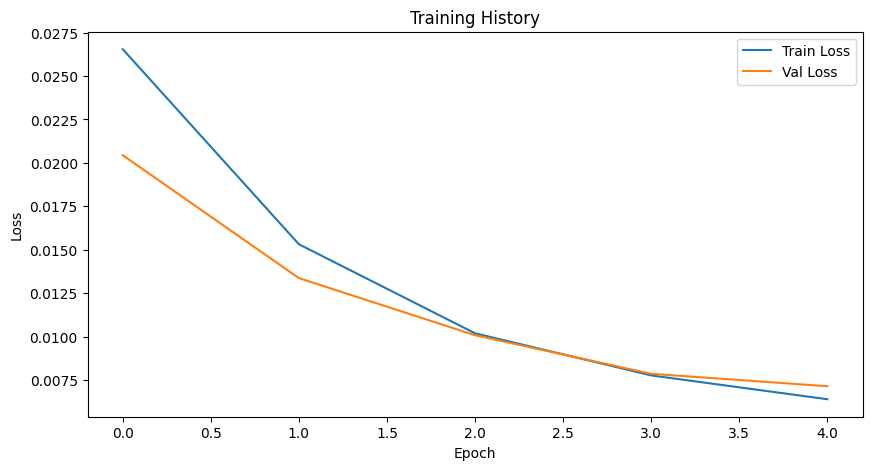

In [12]:
# Cell 11: Training Function
def train_proper_model(model, train_loader, val_loader, epochs=5):
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        for images, masks, _ in train_loader:
            try:
                images, masks = images.to(device), masks.to(device)
                
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks.unsqueeze(1))
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                batch_count += 1
                
                if batch_count % 20 == 0:
                    print(f'Batch {batch_count}, Loss: {loss.item():.4f}')
                    
            except Exception as e:
                print(f"Training batch error: {e}")
                continue
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for images, masks, _ in val_loader:
                try:
                    images, masks = images.to(device), masks.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, masks.unsqueeze(1))
                    val_loss += loss.item()
                    val_batch_count += 1
                except Exception as e:
                    print(f"Validation batch error: {e}")
                    continue
        
        if batch_count > 0 and val_batch_count > 0:
            train_epoch_loss = train_loss / batch_count
            val_epoch_loss = val_loss / val_batch_count
            
            train_losses.append(train_epoch_loss)
            val_losses.append(val_epoch_loss)
            
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')
        else:
            print(f'Epoch {epoch+1}/{epochs} skipped due to errors')
    
    # Plot training history if we have data
    if train_losses:
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training History')
        plt.show()
    
    return model

print("Starting training...")
trained_model = train_proper_model(model, train_loader, val_loader, epochs=5)

In [13]:
# Cell 12: Quick Model Test
def quick_model_test(model, test_loader):
    """Quick test to see if model is working"""
    model.eval()
    
    with torch.no_grad():
        for images, masks, case_ids in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs)
            
            print(f"Input range: [{images.min():.3f}, {images.max():.3f}]")
            print(f"Output range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Prediction range: [{predictions.min():.3f}, {predictions.max():.3f}]")
            print(f"Mask range: [{masks.min():.3f}, {masks.max():.3f}]")
            
            # Calculate basic metrics
            pred_binary = (predictions > 0.5).float()
            accuracy = (pred_binary == masks.unsqueeze(1)).float().mean()
            print(f"Sample accuracy: {accuracy.item():.4f}")
            break

print("Testing model output...")
quick_model_test(trained_model, val_loader)

Testing model output...
Input range: [-2.118, 2.640]
Output range: [-7.581, -4.062]
Prediction range: [0.001, 0.017]
Mask range: [0.000, 0.000]
Sample accuracy: 1.0000


In [14]:
# Cell 13: RLE Encoding Function
def rle_encode(mask):
    """
    Encode mask to run-length encoding
    """
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [15]:
# Cell 14: Test Image Prediction
def predict_test_image(model, image_path, device, img_size=256):
    """Predict forgery for a test image"""
    try:
        # Load image
        image = cv2.imread(image_path)
        if image is None:
            return "authentic"
        
        original_shape = image.shape[:2]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Resize for model
        image_resized = cv2.resize(image, (img_size, img_size))
        
        # Transform
        transform = get_transforms('val', img_size)
        augmented = transform(image=image_resized)
        image_tensor = augmented['image'].unsqueeze(0).to(device)
        
        # Predict
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()
            pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
        
        # Resize back to original
        pred_mask_resized = cv2.resize(pred_mask_binary, (original_shape[1], original_shape[0]))
        
        # Check if any forgery detected
        if pred_mask_resized.sum() == 0:
            return "authentic"
        else:
            return rle_encode(pred_mask_resized)
            
    except Exception as e:
        print(f"Error processing image: {e}")
        return "authentic"

In [16]:
# Cell 15: Create Submission
# Load sample submission
sample_submission = pd.read_csv('/home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/sample_submission.csv')
print(f"Processing {len(sample_submission)} test cases...")

# Create submissions
submissions = []
test_images_dir = '/home/swatson/work/MachineLearning/kaggle/ScientificImageForgeryDetection/test_images'

for i, case_id in enumerate(sample_submission['case_id']):
    if i % 100 == 0:
        print(f"Processed {i}/{len(sample_submission)} cases...")
    
    # Find test image
    image_path = None
    for ext in ['.jpg', '.png', '.tif', '.tiff', '.jpeg','.npy']:
        path = os.path.join(test_images_dir, f"{case_id}{ext}")
        if os.path.exists(path):
            image_path = path
            break
    
    if image_path is None:
        annotation = "authentic"
    else:
        annotation = predict_test_image(trained_model, image_path, device)
    
    submissions.append({'case_id': case_id, 'annotation': annotation})

# Create final submission
final_submission = pd.DataFrame(submissions)
final_submission.to_csv('submission.csv', index=False)
print("✓ Submission file created: submission.csv")

Processing 1 test cases...
Processed 0/1 cases...
✓ Submission file created: submission.csv


In [17]:
# Cell 16: Final Analysis
authentic_count = (final_submission['annotation'] == 'authentic').sum()
forged_count = len(final_submission) - authentic_count

print("=== FINAL SUBMISSION ===")
print(f"Total cases: {len(final_submission)}")
print(f"Authentic: {authentic_count} ({authentic_count/len(final_submission)*100:.1f}%)")
print(f"Forged: {forged_count} ({forged_count/len(final_submission)*100:.1f}%)")
print(f"\nFirst 5 predictions:")
print(final_submission.head())


=== FINAL SUBMISSION ===
Total cases: 1
Authentic: 1 (100.0%)
Forged: 0 (0.0%)

First 5 predictions:
   case_id annotation
0       45  authentic
